In [1]:
!pip install --force-reinstall git+https://github.com/yhhc2/IsoRanker.git

  Cloning https://github.com/yhhc2/IsoRanker.git to /tmp/pip-req-build-54m1tl3r
  Running command git clone --filter=blob:none --quiet https://github.com/yhhc2/IsoRanker.git /tmp/pip-req-build-54m1tl3r
  Resolved https://github.com/yhhc2/IsoRanker.git to commit f78ca876e7e6534f2e33d7e53074cdeca91d1d76
  Preparing metadata (setup.py) ... done
  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached statsmodels-0.14.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pyreadr-0.5.3-cp312-cp312-manylinux_2_17_x86_

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [3]:
# Import functions from the package
from IsoRanker import (
    filter_based_on_counts,
    apply_hypothesis_test,
    calculate_z_score,
    NMD_test_statistic,
    Noncyclo_Expression_Outlier_LOE,
    Noncyclo_Expression_Outlier_GOE,
    Cyclo_Expression_Outlier_GOE,
    NMD_rare_steady_state_transcript,
    Noncyclo_Allelic_Imbalance,
    Cyclo_Allelic_Imbalance,
    calculate_ranks_for_sample,
    create_expression_matrix,
    create_long_format,
    process_hypothesis_test,
    update_files_with_haplotype_info,
    merge_tsvs_by_keyword, 
    process_vep_vcf, 
    merge_haplotype_data, 
    process_phenotype_data,
    process_and_plot_pca,
    analyze_isoforms,
    process_pileup
)


## Assign input paths

#### Option 1: If creating expression matrix from PacBio Isoseq pipeline, please uncomment and specify read_stat_path and sample_info_with_haplotype_location_path, otherwise comment out the whole block:

In [4]:
## Option 1 ##

# Provides every single read, which sample each read came from, and the isoform asssociated with each read
read_stat_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Input/read_stats.txt"

# Assigns samples to patients, cyclo/non-cyclo, and haplotypes
sample_info_with_haplotype_location_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Input/Sample_info.tsv"

# Update read_stat and sample_info file with haplotype information
update_files_with_haplotype_info(sample_info_with_haplotype_location_path, read_stat_path, ".")

# Provides every single read, which sample each read came from, and the isoform asssociated with each read
read_stat_path = "updated_read_stats.txt.gz" # This should NOT be edited if using option 1
sample_info_path = "updated_sample_info.tsv.gz" # This should NOT be edited if using option 1

# Assigns samples to patients, cyclo/non-cyclo, and haplotypes
sample_info = pd.read_csv(sample_info_path, sep="\t")

# Create the expression matrix and save it to a file
expression_matrix = create_expression_matrix(read_stat_path, output_file="expression_matrix.tsv.gz") # This should NOT be edited if using option 1

## Option 1 ##

Processing haplotype assignment file for Sample1
Processing haplotype assignment file for Sample2
Processing haplotype assignment file for Sample3
Processing haplotype assignment file for Sample4
Processing haplotype assignment file for Sample5
Processing haplotype assignment file for Sample6
Processing haplotype assignment file for Sample7
Processing haplotype assignment file for Sample8
Processing haplotype assignment file for Sample9
Processing haplotype assignment file for Sample10
Processing haplotype assignment file for Sample11
Processing haplotype assignment file for Sample12
Processing haplotype assignment file for Sample13
Processing haplotype assignment file for Sample14
Processing haplotype assignment file for Sample15
Processing haplotype assignment file for Sample16
Processing haplotype assignment file for Sample17
Processing haplotype assignment file for Sample18
Processing haplotype assignment file for Sample19
Processing haplotype assignment file for Sample20
Processin

#### Option 2: If using expression matrix directly, please uncomment and specify expression_matrix_path and sample_info_path, otherwise comment out the whole block.
- Please see Output/intermediate/expression_matrix.tsv.gz for an example of how to format expression matrix.
- Please see Output/intermediate/updated_sample_info.tsv.gz for an example of how to format sample info.

In [5]:
## Option 2 ##

# expression_matrix_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Output/intermediate/expression_matrix.tsv.gz"
# sample_info_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Output/intermediate/updated_sample_info.tsv.gz"

# expression_matrix = pd.read_csv(expression_matrix_path, compression = "gzip", index_col=0, sep="\t")
# sample_info = pd.read_csv(sample_info_path, compression = "gzip", sep="\t")

## Option 2 ##

In [6]:
# Provides pigeon annotation for isoforms
classification_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Input/filtered_classification.txt"
classification_data = pd.read_csv(classification_path, sep="\t")

# Provide omim information for genes
genemap_path = "/mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker_testing/genemap2.txt"
genemap = pd.read_csv(genemap_path, sep='\t', skiprows=3) # Read the file, skipping the first 3 rows
genemap = genemap[genemap['Approved Gene Symbol'].notnull()]

# Reference file for SRSF6 QC pileup
reference_fasta_path = "/gscratch/stergachislab/assemblies/simple-names/hg38.fa"

## Convert isoform matrix to long format, then add gene information to enable gene-level analysis

In [7]:
# Generate the long-format dataFrame and adding cyclo/noncyclo as well as haplotype labels and calculate TPM
long_format_df = create_long_format(expression_matrix, sample_info)


In [8]:
# Select only the 'isoform' and 'associated_gene' columns from classification_data
classification_subset = classification_data[['isoform', 'associated_gene']]
# Merge the classification subset with the long_format_df
long_format_annotated = long_format_df.merge(
    classification_subset,
    left_on="Isoform",   # Match isoform IDs in long_format_df
    right_on="isoform",  # Match isoform IDs in classification_subset
    how="left"           # Keep all rows from long_format_df, even if there's no match in classification_subset
).drop(columns=["isoform"])  # Drop redundant 'isoform' column from classification_subset

long_format_annotated.to_csv("long_format_annotated.tsv.gz", index=False, compression = "gzip", sep="\t")


## Calculate test stat and rankings

In [9]:
# Calculate for all hypothesis tests
test_stat_funcs = [
    ("NMD", NMD_test_statistic),
    ("Noncyclo_LOE", Noncyclo_Expression_Outlier_LOE),
    ("Noncyclo_GOE", Noncyclo_Expression_Outlier_GOE),
    ("Cyclo_GOE", Cyclo_Expression_Outlier_GOE),
    ("NMD_rare_steady_state_transcript", NMD_rare_steady_state_transcript),
    ("Nonyclo_Allelic_Imbalance", Noncyclo_Allelic_Imbalance),
    ("Cyclo_Allelic_Imbalance", Cyclo_Allelic_Imbalance)
]

# Store full results to generate lookup table
full_ranked_gene_data = []

#Gene level
for test_name, test_func in test_stat_funcs:
        print(f"Processing test statistic: {test_name}")

        # Apply the process_hypothesis_test function
        ranked_data = process_hypothesis_test(
            filtered_data=long_format_annotated, 
            group_col='Isoform', 
            test_statistic_func=test_func, 
            gene_group_col='associated_gene', 
            gene_level=True, 
            bin_proportion=0.01, 
            filter_before_ranking=True, 
            filter_count_threshold=10)

        # Append tuple (test_name, ranked_data) to the list
        full_ranked_gene_data.append((test_name, ranked_data))

        filtered_ranked_data = ranked_data[ranked_data["rank_top_99_5_percentile"] <= 25]

        # Add OMIM data to genes
        filtered_ranked_data = filtered_ranked_data.merge(
            genemap[['Approved Gene Symbol', 'Phenotypes']],  # Select relevant columns from genemap
            how='left',  # Perform a left join to keep all rows from filtered_ranked_data
            left_on='associated_gene',  # Column in filtered_ranked_data to join on
            right_on='Approved Gene Symbol'  # Column in genemap to join on
        )
        # Drop the 'Approved Gene Name' column if it is no longer needed
        filtered_ranked_data = filtered_ranked_data.drop(columns=['Approved Gene Symbol'])

        # Save the results to a tsv file
        output_dir = ""
        output_file = os.path.join(output_dir, f"{test_name}_gene_top_ranked_data.tsv.gz")
        filtered_ranked_data.to_csv(output_file, index=False, compression = "gzip", sep="\t")
        print(f"Results saved to {output_file}")


Processing test statistic: NMD
Results saved to NMD_gene_top_ranked_data.tsv.gz
Processing test statistic: Noncyclo_LOE
Results saved to Noncyclo_LOE_gene_top_ranked_data.tsv.gz
Processing test statistic: Noncyclo_GOE
Results saved to Noncyclo_GOE_gene_top_ranked_data.tsv.gz
Processing test statistic: Cyclo_GOE
Results saved to Cyclo_GOE_gene_top_ranked_data.tsv.gz
Processing test statistic: NMD_rare_steady_state_transcript
Results saved to NMD_rare_steady_state_transcript_gene_top_ranked_data.tsv.gz
Processing test statistic: Nonyclo_Allelic_Imbalance
Results saved to Nonyclo_Allelic_Imbalance_gene_top_ranked_data.tsv.gz
Processing test statistic: Cyclo_Allelic_Imbalance
Results saved to Cyclo_Allelic_Imbalance_gene_top_ranked_data.tsv.gz


In [10]:
test_stat_funcs = [
    ("NMD", NMD_test_statistic),
    ("Noncyclo_LOE", Noncyclo_Expression_Outlier_LOE),
    ("Noncyclo_GOE", Noncyclo_Expression_Outlier_GOE),
    ("Cyclo_GOE", Cyclo_Expression_Outlier_GOE)
]

#Isoform level
for test_name, test_func in test_stat_funcs:
        print(f"Processing test statistic: {test_name}")

        # Apply the process_hypothesis_test function
        ranked_data = process_hypothesis_test(
            filtered_data=long_format_annotated, 
            group_col='Isoform', 
            test_statistic_func=test_func, 
            gene_group_col='associated_gene', 
            gene_level=False, 
            bin_proportion=0.01, 
            filter_before_ranking=True, 
            filter_count_threshold=10)

        filtered_ranked_data = ranked_data[ranked_data["rank_top_99_5_percentile"] <= 25]

        # Add OMIM data to genes
        filtered_ranked_data = filtered_ranked_data.merge(
            genemap[['Approved Gene Symbol', 'Phenotypes']],  # Select relevant columns from genemap
            how='left',  # Perform a left join to keep all rows from filtered_ranked_data
            left_on='associated_gene',  # Column in filtered_ranked_data to join on
            right_on='Approved Gene Symbol'  # Column in genemap to join on
        )
        # Drop the 'Approved Gene Name' column if it is no longer needed
        filtered_ranked_data = filtered_ranked_data.drop(columns=['Approved Gene Symbol'])

        # Save the results to a tsv file
        output_dir = ""
        output_file = os.path.join(output_dir, f"{test_name}_isoform_top_ranked_data.tsv.gz")
        filtered_ranked_data.to_csv(output_file, index=False, compression = "gzip", sep="\t")
        print(f"Results saved to {output_file}")

Processing test statistic: NMD
Results saved to NMD_isoform_top_ranked_data.tsv.gz
Processing test statistic: Noncyclo_LOE
Results saved to Noncyclo_LOE_isoform_top_ranked_data.tsv.gz
Processing test statistic: Noncyclo_GOE
Results saved to Noncyclo_GOE_isoform_top_ranked_data.tsv.gz
Processing test statistic: Cyclo_GOE
Results saved to Cyclo_GOE_isoform_top_ranked_data.tsv.gz


## Combine all output files

In [11]:
# Isoform
directory = "."
keyword = "isoform" 
output_tsv = os.path.join(directory, f"merged_ranked_{keyword}.tsv.gz")
merge_tsvs_by_keyword(directory, keyword, output_tsv)

# Gene
directory = "."
keyword = "gene"
output_tsv = os.path.join(directory, f"merged_ranked_{keyword}.tsv.gz")
merge_tsvs_by_keyword(directory, keyword, output_tsv)


Merged 6 'isoform' files into: ./merged_ranked_isoform.tsv.gz
Merged 11 'gene' files into: ./merged_ranked_gene.tsv.gz


## Lookup tables

In [12]:
# Collapse long_format_annotated by summing TPM values per Sample and Gene
sample_gene_rankings_lookup_table = long_format_annotated.groupby(["Sample", "associated_gene"], as_index=False).agg(
    {"Cyclo_TPM": "sum", "Noncyclo_TPM": "sum"}
)

# Now merge the ranked gene-level data
for test_name, df in full_ranked_gene_data:
    # Rename rank column to be test-specific
    df_renamed = df.rename(columns={"rank_top_99_5_percentile": f"{test_name}_rank_top_99_5_percentile"})

    # Keep only relevant columns
    df_renamed = df_renamed[["Sample", "associated_gene", f"{test_name}_rank_top_99_5_percentile"]]

    # Merge into merged_df using outer join
    sample_gene_rankings_lookup_table = pd.merge(sample_gene_rankings_lookup_table, df_renamed, on=["Sample", "associated_gene"], how="outer")

# Save as a compressed tsv (gzip format)
sample_gene_rankings_lookup_table.to_csv("sample_gene_rankings_lookup_table.tsv.gz", index=False, compression="gzip", sep="\t")

# Group by gene (associated_gene) and compute median, Q1 (25th percentile), and Q3 (75th percentile)
gene_coverage_lookup_table = sample_gene_rankings_lookup_table.groupby("associated_gene").agg(
    Cyclo_TPM_median=("Cyclo_TPM", "median"),
    Cyclo_TPM_Q1=("Cyclo_TPM", lambda x: x.quantile(0.25)),  # 25th percentile
    Cyclo_TPM_Q3=("Cyclo_TPM", lambda x: x.quantile(0.75)),  # 75th percentile
    Cyclo_TPM_min=("Cyclo_TPM", "min"),  # Minimum value
    Cyclo_TPM_max=("Cyclo_TPM", "max"),  # Maximum value

    Noncyclo_TPM_median=("Noncyclo_TPM", "median"),
    Noncyclo_TPM_Q1=("Noncyclo_TPM", lambda x: x.quantile(0.25)),  # 25th percentile
    Noncyclo_TPM_Q3=("Noncyclo_TPM", lambda x: x.quantile(0.75)),  # 75th percentile
    Noncyclo_TPM_min=("Noncyclo_TPM", "min"),  # Minimum value
    Noncyclo_TPM_max=("Noncyclo_TPM", "max")   # Maximum value
).reset_index()

gene_coverage_lookup_table.to_csv("gene_coverage_lookup_table.tsv.gz", index=False, compression="gzip", sep="\t")



## QC

In [13]:
###################################
# PCA
###################################

pca_results = process_and_plot_pca(long_format_annotated, output_pdf="pca_plot.pdf", grouping_col = "associated_gene")

In [14]:
###################################
# Gene diversity
###################################

analyze_isoforms(long_format_annotated, "gene_diversity.tsv.gz", "associated_gene")

###################################
# Isoform diversity
###################################

analyze_isoforms(long_format_annotated, "isoform_diversity.tsv.gz", "Isoform")


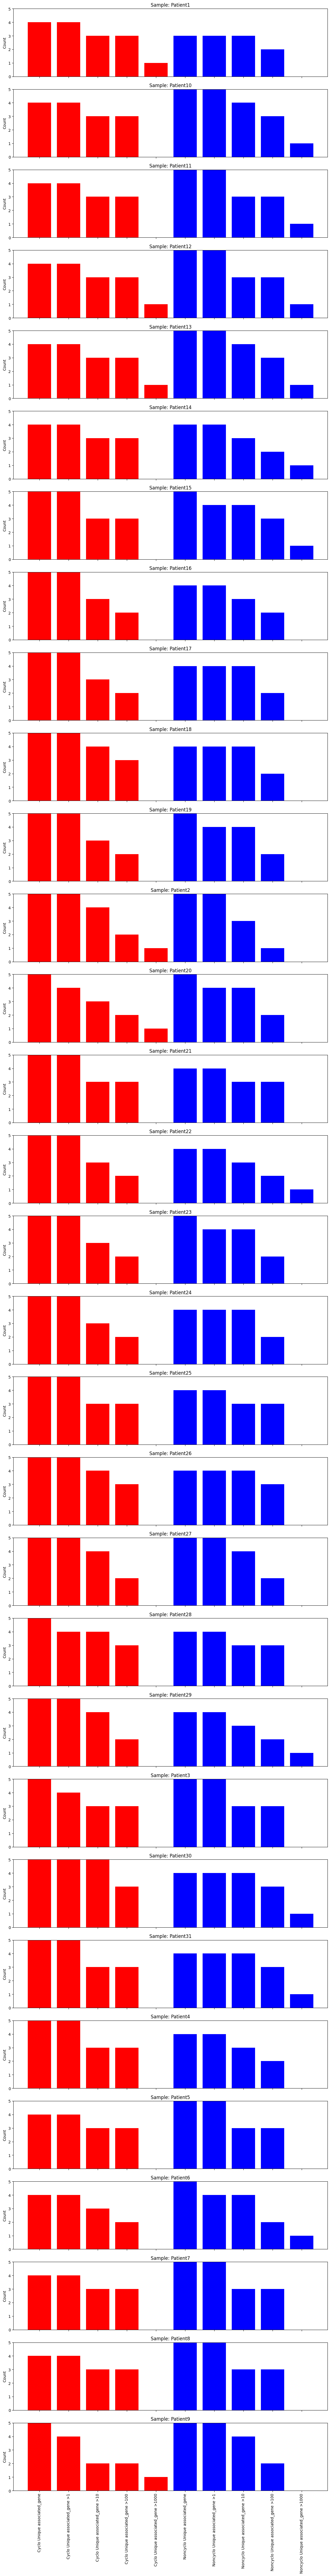

In [15]:
###################################
# Gene diversity plot
###################################

df = pd.read_csv("gene_diversity.tsv.gz", compression = "gzip", sep="\t")

# Drop 'Cyclo Total Reads' and 'Noncyclo Total Reads' columns
df_filtered = df.drop(columns=["Cyclo Total Reads", "Noncyclo Total Reads"])

# Define colors for Cyclo and Noncyclo categories
cyclo_color = "red"
noncyclo_color = "blue"

# Determine a common y-axis limit for all plots
y_max = df_filtered.drop(columns=["Sample"]).max().max()

# Create subplots for each sample
num_samples = len(df_filtered["Sample"])
fig, axes = plt.subplots(nrows=num_samples, figsize=(12, num_samples * 3), sharex=True, sharey=True)

# If only one sample, make axes iterable
if num_samples == 1:
    axes = [axes]

# Loop through each sample and create a separate bar plot
for ax, sample in zip(axes, df_filtered["Sample"]):
    sample_data = df_filtered[df_filtered["Sample"] == sample].drop(columns=["Sample"]).T
    colors = [cyclo_color if "Cyclo" in col else noncyclo_color for col in sample_data.index]
    
    ax.bar(sample_data.index, sample_data.iloc[:, 0], color=colors)
    ax.set_title(f"Sample: {sample}")
    ax.set_ylabel("Count")
    ax.set_ylim(0, y_max)  # Set common y-axis limit
    ax.tick_params(axis="x", rotation=90)

# Formatting
plt.tight_layout()

# Save to PDF
plt.savefig("gene_diversity.pdf", format="pdf")


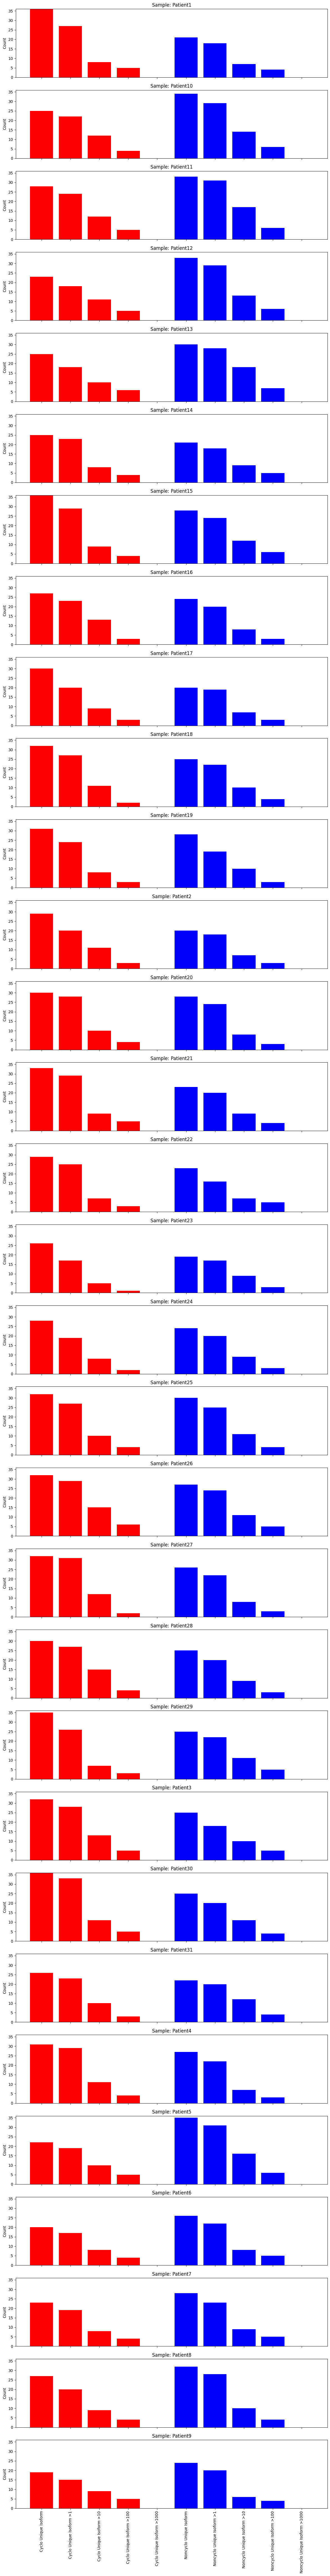

In [16]:
###################################
# Isoform diversity plot
###################################

df = pd.read_csv("isoform_diversity.tsv.gz", compression = "gzip", sep="\t")

# Drop 'Cyclo Total Reads' and 'Noncyclo Total Reads' columns
df_filtered = df.drop(columns=["Cyclo Total Reads", "Noncyclo Total Reads"])

# Define colors for Cyclo and Noncyclo categories
cyclo_color = "red"
noncyclo_color = "blue"

# Determine a common y-axis limit for all plots
y_max = df_filtered.drop(columns=["Sample"]).max().max()

# Create subplots for each sample
num_samples = len(df_filtered["Sample"])
fig, axes = plt.subplots(nrows=num_samples, figsize=(12, num_samples * 3), sharex=True, sharey=True)

# If only one sample, make axes iterable
if num_samples == 1:
    axes = [axes]

# Loop through each sample and create a separate bar plot
for ax, sample in zip(axes, df_filtered["Sample"]):
    sample_data = df_filtered[df_filtered["Sample"] == sample].drop(columns=["Sample"]).T
    colors = [cyclo_color if "Cyclo" in col else noncyclo_color for col in sample_data.index]
    
    ax.bar(sample_data.index, sample_data.iloc[:, 0], color=colors)
    ax.set_title(f"Sample: {sample}")
    ax.set_ylabel("Count")
    ax.set_ylim(0, y_max)  # Set common y-axis limit
    ax.tick_params(axis="x", rotation=90)

# Formatting
plt.tight_layout()

# Save to PDF
plt.savefig("isoform_diversity.pdf", format="pdf")


Processing BAM file: /mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Input/bam_files/Sample1_untreated_hg38_example.bam from source: Patient1_noncyclo
Processing BAM file: /mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Input/bam_files/Sample2_treated_hg38_example.bam from source: Patient1_cyclo
Processing BAM file: /mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Input/bam_files/Sample3_untreated_hg38_example.bam from source: Patient2_noncyclo
Processing BAM file: /mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Input/bam_files/Sample4_treated_hg38_example.bam from source: Patient2_cyclo
Processing BAM file: /mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/examples/Expression_AllelicImbalance_NMD/Input/bam_files/Sample5_untreated_hg38_example.bam from source: Patient3_noncyclo
Processing BAM file:

/tmp/ipykernel_40428/2802082044.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x="Source", y="Exonic_Proportion", edgecolor="black", palette=colors)


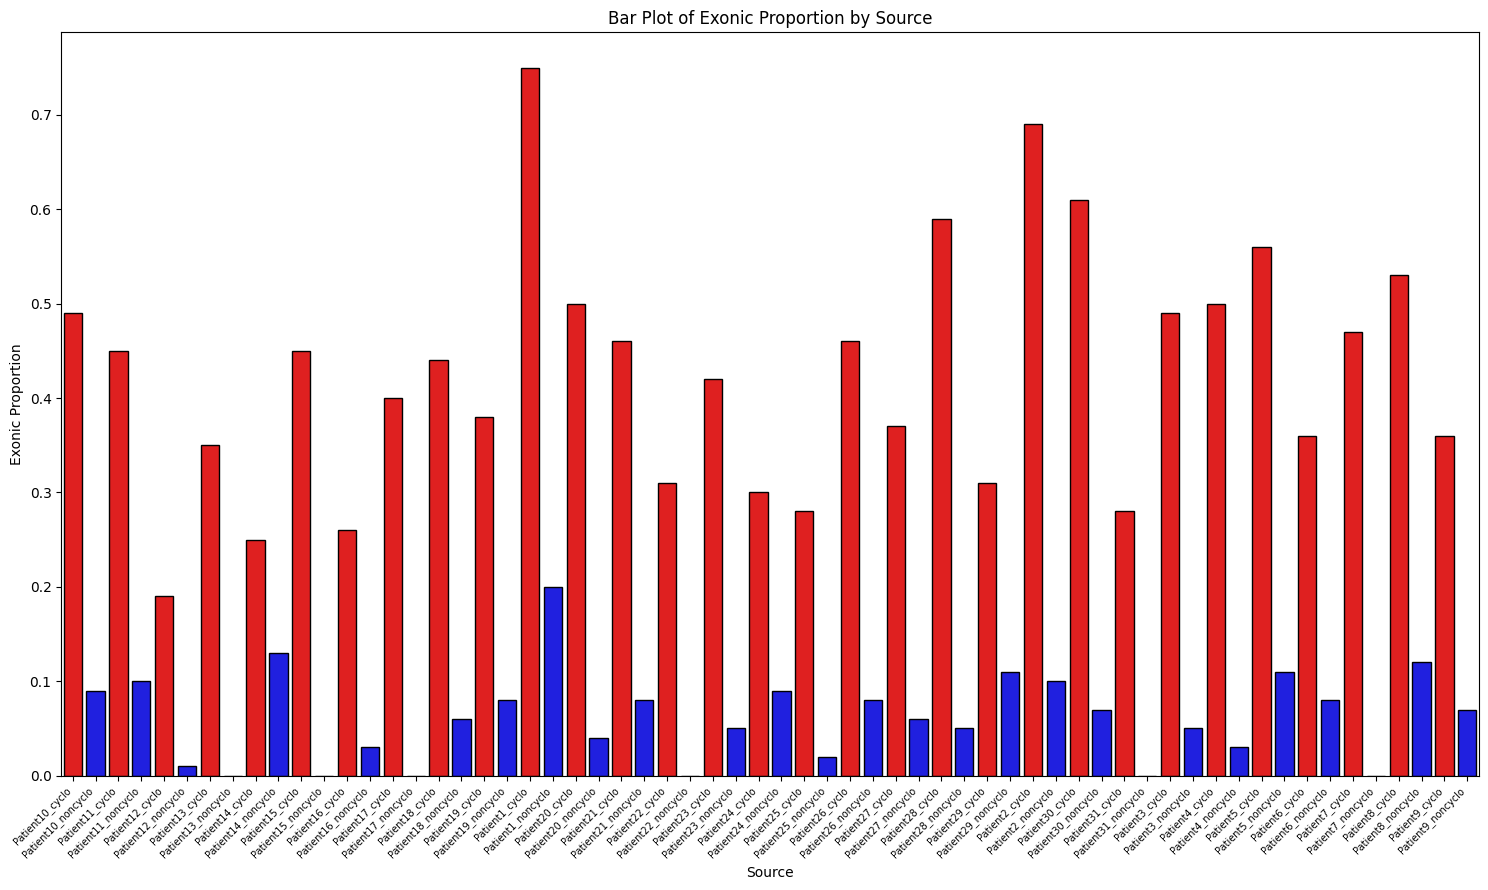

In [17]:
if "bam_file" in sample_info.columns and sample_info["bam_file"].notna().any():
    
    ###################################
    # SRSF6
    ###################################
    process_pileup(df=sample_info, reference_fasta=reference_fasta_path, chromosome="chr20", position=43459200, output_file="SRSF6.tsv.gz")

    ###################################
    # SRSF6 plot 
    ###################################
    SRSF6_df = pd.read_csv("SRSF6.tsv.gz", compression="gzip", sep="\t")

    # Sort DataFrame by source
    df_sorted = SRSF6_df.sort_values(by="Source")

    # Define colors based on condition
    colors = ["red" if "_cyclo" in source else "blue" for source in df_sorted["Source"]]
    
    # Plot bar chart
    plt.figure(figsize=(15, 9))
    sns.barplot(data=df_sorted, x="Source", y="Exonic_Proportion", edgecolor="black", palette=colors)
    
    # Labeling and formatting
    plt.xlabel("Source")
    plt.ylabel("Exonic Proportion")
    plt.title("Bar Plot of Exonic Proportion by Source")
    plt.xticks(rotation=45, fontsize=7, ha="right")  # Adjust alignment to prevent cutoff

    plt.tight_layout()
    
    # Save to PDF
    plt.savefig("SRSF6_exonic_proportion.pdf", format="pdf")


## Organizing output files

In [18]:
import os
import shutil

# Define folder names
OUTPUT_FOLDER = "Output"
QC_FOLDER = os.path.join(OUTPUT_FOLDER, "qc")
BROWSER_FOLDER = os.path.join(OUTPUT_FOLDER, "browser")
LOOKUP_TABLES_FOLDER = os.path.join(BROWSER_FOLDER, "lookup_tables")
COMBINED_RESULTS_FOLDER = os.path.join(BROWSER_FOLDER, "combined_results")
SEPARATED_RESULTS_FOLDER = os.path.join(BROWSER_FOLDER, "separated_results")
INTERMEDIATE_FOLDER = os.path.join(OUTPUT_FOLDER, "intermediate")

# Ensure directories exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(QC_FOLDER, exist_ok=True)
os.makedirs(BROWSER_FOLDER, exist_ok=True)
os.makedirs(LOOKUP_TABLES_FOLDER, exist_ok=True)
os.makedirs(COMBINED_RESULTS_FOLDER, exist_ok=True)
os.makedirs(SEPARATED_RESULTS_FOLDER, exist_ok=True)
os.makedirs(INTERMEDIATE_FOLDER, exist_ok=True)


# Define file categories
qc_files = {
    "pca_plot.pdf",
    "gene_diversity.tsv.gz",
    "isoform_diversity.tsv.gz",
    "SRSF6.tsv.gz",
    "SRSF6_exonic_proportion.pdf",
    "isoform_diversity.pdf",
    "gene_diversity.pdf"
}

lookup_table_files = {
    "sample_gene_rankings_lookup_table.tsv.gz",
    "gene_coverage_lookup_table.tsv.gz"
}

combined_results_files = {
    "merged_ranked_gene_with_phenotype.tsv.gz",
    "merged_ranked_isoform_with_phenotype.tsv.gz",
    "merged_ranked_gene.tsv.gz",
    "merged_ranked_isoform.tsv.gz"
}

separated_results_files = {
    "Cyclo_Allelic_Imbalance_gene_top_ranked_data.tsv.gz",
    "Cyclo_GOE_gene_top_ranked_data.tsv.gz",
    "Cyclo_GOE_isoform_top_ranked_data.tsv.gz",
    "NMD_gene_top_ranked_data.tsv.gz",
    "NMD_isoform_top_ranked_data.tsv.gz",
    "NMD_rare_steady_state_transcript_gene_top_ranked_data.tsv.gz",
    "Noncyclo_GOE_gene_top_ranked_data.tsv.gz",
    "Noncyclo_GOE_isoform_top_ranked_data.tsv.gz",
    "Noncyclo_LOE_gene_top_ranked_data.tsv.gz",
    "Noncyclo_LOE_isoform_top_ranked_data.tsv.gz",
    "Nonyclo_Allelic_Imbalance_gene_top_ranked_data.tsv.gz"
}

browser_files = lookup_table_files | combined_results_files | separated_results_files

# Get all `.gz` files in the current directory
all_gz_files = {f for f in os.listdir() if f.endswith(".gz")}

# Find files that should go into intermediate (everything not in QC or Browser)
intermediate_files = all_gz_files - qc_files - browser_files

# Function to move files
def move_files(file_list, destination_folder):
    for file in file_list:
        if os.path.exists(file):  # Ensure the file exists before moving
            shutil.move(file, os.path.join(destination_folder, file))
        else:
            print(f"Warning: {file} not found, skipping.")

# Move files to their respective folders
move_files(qc_files, QC_FOLDER)
move_files(lookup_table_files, LOOKUP_TABLES_FOLDER)
move_files(combined_results_files, COMBINED_RESULTS_FOLDER)
move_files(separated_results_files, SEPARATED_RESULTS_FOLDER)
move_files(intermediate_files, INTERMEDIATE_FOLDER)

print("File organization complete!")


File organization complete!


## Zipping/Unzipping all the files

In [19]:
import os
import gzip
import shutil

def unzip_gz_files_recursively(directory, output_dir):
    """
    Recursively unzips all .gz files from `directory` and its subdirectories, 
    preserving the folder structure in `output_dir`.
    
    Parameters:
    - directory (str): Root directory to search for .gz files.
    - output_dir (str): Destination directory where extracted files will be saved.
    """
    for root, _, files in os.walk(directory):  # Recursively walk through directories
        for file in files:
            if file.endswith(".gz"):
                gz_path = os.path.join(root, file)
                
                # Preserve subdirectory structure in the output directory
                relative_path = os.path.relpath(root, directory)  # Get relative path
                target_dir = os.path.join(output_dir, relative_path)
                os.makedirs(target_dir, exist_ok=True)  # Create subdirectories if needed
                
                output_path = os.path.join(target_dir, file[:-3])  # Remove .gz extension
                
                # Extract file
                with gzip.open(gz_path, 'rb') as gz_file, open(output_path, 'wb') as out_file:
                    shutil.copyfileobj(gz_file, out_file)

                print(f"Extracted: {gz_path} -> {output_path}")

# Example usage
unzip_gz_files_recursively(
    ".", 
    "Output_Unzipped"
)


Extracted: ./Output/qc/isoform_diversity.tsv.gz -> Output_Unzipped/Output/qc/isoform_diversity.tsv
Extracted: ./Output/qc/SRSF6.tsv.gz -> Output_Unzipped/Output/qc/SRSF6.tsv
Extracted: ./Output/qc/gene_diversity.tsv.gz -> Output_Unzipped/Output/qc/gene_diversity.tsv
Extracted: ./Output/browser/separated_results/NMD_rare_steady_state_transcript_gene_top_ranked_data.tsv.gz -> Output_Unzipped/Output/browser/separated_results/NMD_rare_steady_state_transcript_gene_top_ranked_data.tsv
Extracted: ./Output/browser/separated_results/Cyclo_Allelic_Imbalance_gene_top_ranked_data.tsv.gz -> Output_Unzipped/Output/browser/separated_results/Cyclo_Allelic_Imbalance_gene_top_ranked_data.tsv
Extracted: ./Output/browser/separated_results/Cyclo_GOE_gene_top_ranked_data.tsv.gz -> Output_Unzipped/Output/browser/separated_results/Cyclo_GOE_gene_top_ranked_data.tsv
Extracted: ./Output/browser/separated_results/Noncyclo_LOE_gene_top_ranked_data.tsv.gz -> Output_Unzipped/Output/browser/separated_results/Noncycl

## Unit tests

In [20]:
# Run unit tests
# !python -m unittest discover -s /mmfs1/gscratch/stergachislab/yhhc/projects/IsoRanker/tests -p "test_all.py"